In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from sklearn import decomposition

np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Clustering on all profiles

In [31]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts'

all_selected = selected_009266 + selected_009265 + selected_57
event_type = 'BGR'

label_mx = {
    '009266': 0,
    '009265': 1,
    '57': 2
}
get_label = lambda session: label_mx[session.split('_')[0]]

psths  = []
labels = []
bins   = None
for i, session in enumerate(all_selected):
    animal   = session.split('_')[0]
    psth_file  = os.path.join(dst_path, animal, session, 'analysis', 'psth_micro.h5')

    with h5py.File(psth_file, 'r') as f:
        for unit_name in f['BGR']:
            if int(unit_name[0]) > 2:
                continue
            psths.append(np.array(f['BGR'][unit_name]['profile_stats'][1]))
            labels.append(get_label(session))
            if bins is None:
                bins = np.array(f['BGR'][unit_name]['profile_stats'][0])

psths = np.array(psths)
labels = np.array(labels)

In [5]:
psths.shape

(1137, 50)

In [6]:
#from sklearn.preprocessing import StandardScaler
#psths_scaled = StandardScaler().fit_transform(psths)

psths_scaled = psths.copy()
for i in range(len(psths)):
    #psths_scaled[i] = psths[i]/np.max(psths[i])
    psths_scaled[i] = stats.zscore(psths[i])

## PCA / ICA

In [8]:
pca_bgr = decomposition.PCA(n_components=10)
pca_bgr.fit(psths_scaled)
pca_fit = pca_bgr.transform(psths_scaled)
pca_bgr.explained_variance_ratio_

array([0.28430963, 0.25034292, 0.14376734, 0.0931175 , 0.04276462,
       0.03144871, 0.02422386, 0.01844636, 0.01278277, 0.01189608])

In [9]:
np.sum(pca_bgr.explained_variance_ratio_)

0.913099794640074

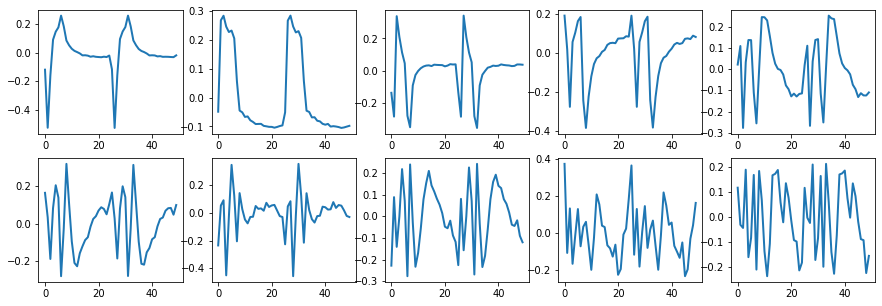

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for i in range(5):
    ax = axes[0][i]
    ax.plot(pca_bgr.components_[i], lw=2)
for i in range(5):
    ax = axes[1][i]
    ax.plot(pca_bgr.components_[5 + i], lw=2)

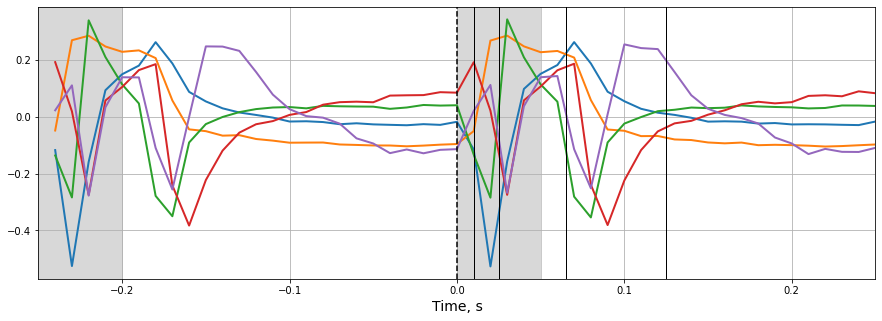

In [11]:
hw = 0.25
bin_size = bins[1] - bins[0]
binning = [10, 25, 65, 125]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for i in range(5):
    ax.plot(bins + bin_size, pca_bgr.components_[i], lw=2)
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.axvspan(-0.25, -0.2, alpha=0.3, color='gray')
ax.set_xlim(-hw, hw)
ax.set_xlabel('Time, s', fontsize=14)
ax.grid()
for x_bin in binning:
    ax.axvline(x_bin/1000, color='black', lw=1)

In [19]:
ica_bgr = decomposition.FastICA(n_components=2)
ica_bgr.fit(psths_scaled)
ica_fit = ica_bgr.transform(psths_scaled)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


## t-SNE / UMAP

In [15]:
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn import decomposition

In [16]:
tsne = TSNE(n_components=2, perplexity=70, random_state=0)
tsne_fit = tsne.fit_transform(psths_scaled)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [17]:
umap_2d = UMAP(n_components=2, n_neighbors=30, min_dist=0.5, random_state=0)
umap_fit = umap_2d.fit_transform(psths_scaled)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


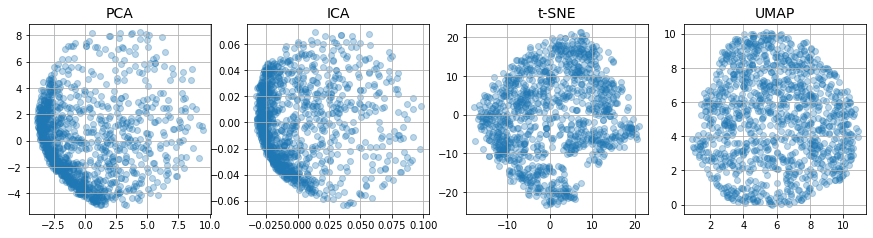

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3.5))

titles = ['PCA', 'ICA', 't-SNE', 'UMAP']
for i, fit in enumerate([pca_fit, ica_fit, tsne_fit, umap_fit]):
    ax = axes[i]
    ax.scatter(fit[:, 0], fit[:, 1], alpha=0.3)
    ax.grid()
    ax.set_title(titles[i], fontsize=14)

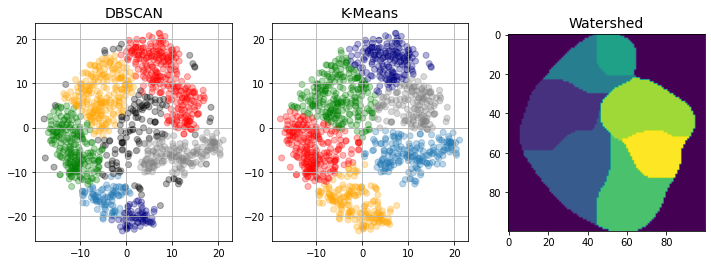

In [27]:
from sklearn.cluster import DBSCAN, KMeans
from skimage.segmentation import watershed
from Behavior.behavior import get_idxs_in_patches, get_extent, density_map

# 1. watershed
extent = get_extent(tsne_fit, margin=5)

# density map
d_map  = density_map(tsne_fit, extent, sigma=0.10, bin_count=100)

# watershed segmentation
mask = d_map > 0.1*d_map.max()
fit_labels = watershed(-d_map, mask=mask)

x_bins = np.linspace(extent[0], extent[1], fit_labels.shape[0]+1)
y_bins = np.linspace(extent[2], extent[3], fit_labels.shape[1]+1)

labels_ev = np.zeros(len(tsne_fit))
for i, record in enumerate(tsne_fit):  # [idxs_succ_ev]
    x_bin_idx = np.where(x_bins > record[0])[0][0] - 1
    y_bin_idx = np.where(y_bins > record[1])[0][0] - 1

    curr_label = fit_labels[x_bin_idx, y_bin_idx]
    labels_ev[i] = curr_label

# 2. DBSCAN
#clustering = DBSCAN(eps=1.36, min_samples=10).fit(tsne_fit)  # kind of good for all 3 animals
#clustering = DBSCAN(eps=2.09, min_samples=25).fit(tsne_fit)
d_clustering = DBSCAN(eps=2.6, min_samples=25).fit(tsne_fit)

# 3. K-Means
k_clustering = KMeans(n_clusters=6, random_state=0).fit(tsne_fit)

# define colors
colors = ['red', 'green', 'blue', 'orange', 'navy', 'cyan', 'black']
colors = ['red', 'green', 'tab:blue', 'orange', 'navy', 'grey', 'black']
#colors = list(reversed(plt.rcParams['axes.prop_cycle'].by_key()['color']))
#colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

d_clrs = [colors[label] for label in d_clustering.labels_]
k_clrs = [colors[label] for label in k_clustering.labels_]
#w_clrs = [colors[label] for label in labels_ev.astype(np.int16)]
clrs = [d_clrs, k_clrs]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(2):
    axes[i].scatter(tsne_fit[:, 0], tsne_fit[:, 1], c=clrs[i], alpha=0.3)
    axes[i].grid()
axes[2].imshow(fit_labels.T)

titles = ['DBSCAN', 'K-Means', 'Watershed']
for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=14)

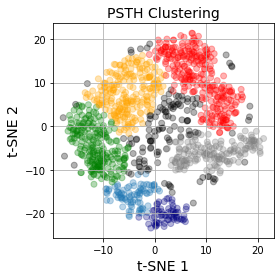

In [37]:
# select clustering
clustering = d_clustering

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(tsne_fit[:, 0], tsne_fit[:, 1], c=d_clrs, alpha=0.3)
ax.set_xlabel('t-SNE 1', fontsize=14)
ax.set_ylabel('t-SNE 2', fontsize=14)
ax.set_title('PSTH Clustering', fontsize=14)
ax.grid()

fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'PSTH_DBSCAN.png'), dpi=300)

In [38]:
clus = np.unique(clustering.labels_)
clu_count = len(clus)
clus, len(np.where([clustering.labels_ == -1])[0])

(array([-1,  0,  1,  2,  3,  4,  5]), 131)

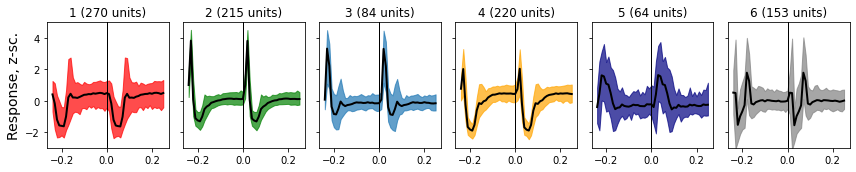

In [56]:
to_plot = psths_scaled

fig, axes = plt.subplots(1, clu_count-1, figsize=(12, 2.5))

for i in range(clu_count-1):
    sel = to_plot[clustering.labels_ == i]
    mean = sel.mean(axis=0)
    conf_l = np.zeros_like(mean)
    conf_h = np.zeros_like(mean)
    for k, col in enumerate(sel.T):
        conf_l[k] = np.percentile(col, 5)
        conf_h[k] = np.percentile(col, 95)
    
    ax = axes[i]
    #for profile in to_plot[clustering.labels_ == i]:
    #    ax.plot(bins + bin_size, profile, color=colors[i], alpha=0.05)
    ax.fill_between(bins + bin_size, conf_l, conf_h, color=colors[i], alpha=0.7)
    ax.plot(bins + bin_size, to_plot[clustering.labels_ == i].mean(axis=0), lw=2, color='black')
    ax.set_ylim(-3, 5)
    ax.axvline(0, color='black', lw=1)
    ax.set_title('%d (%d units)' % (i+1, len(sel)))
    if i == 0:
        ax.set_ylabel('Response, z-sc.', fontsize=14)
    else:
        ax.set_yticklabels([])
        
fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'PSTH_clusters.png'), dpi=300)

### Cluster distribution per animals

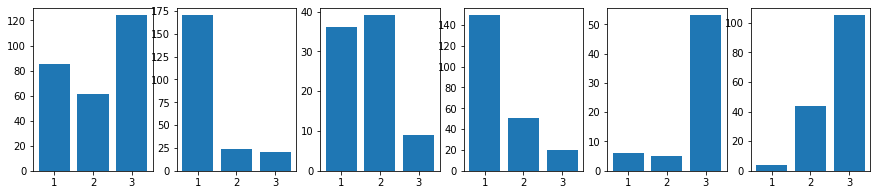

In [525]:
unique_labels = np.unique(labels)

fig, axes = plt.subplots(1, clu_count-1, figsize=(15, 3))

for i in range(clu_count-1):
    ax = axes[i]
    curr_labels = labels[clustering.labels_ == i]
    vals = []
    for j in unique_labels:
        vals.append(len(np.where(curr_labels == j)[0]))
    ax.bar(np.arange(len(unique_labels))+1, vals)

### Principal components - clustering profile means

In [526]:
hw = 0.25
bin_size = bins[1] - bins[0]
binning = [10, 30, 65, 125]

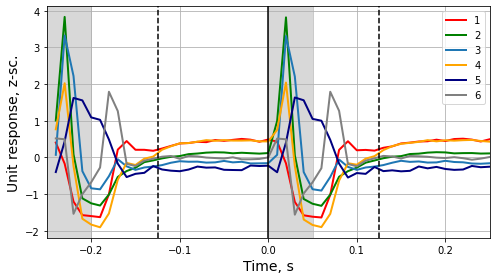

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

for i in range(clu_count-1):
    ax.plot(bins + bin_size, to_plot[clustering.labels_ == i].mean(axis=0), lw=2, color=colors[i], label=str(i+1))
ax.axvline(0, color='black')
ax.axvline(-0.125, color='black', lw=1.5, ls='--')
ax.axvline(0.125, color='black', lw=1.5, ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.axvspan(-0.25, -0.2, alpha=0.3, color='gray')
ax.set_xlim(-hw, hw)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Unit response, z-sc.', fontsize=14)
ax.legend()
ax.grid()

fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'PSTH_cluster_means.png'), dpi=300)

### Mean rates of change

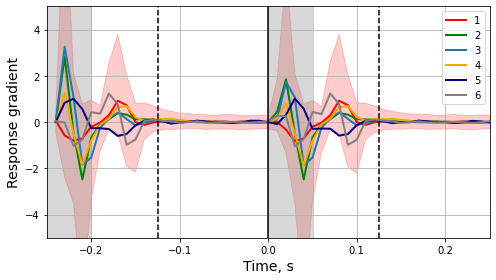

In [66]:
# gradient - no change part
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

for i in range(clu_count-1):
    grad = np.roll(np.gradient(to_plot[clustering.labels_ == i].mean(axis=0)), 1)
    ax.plot(bins + bin_size, grad, lw=2, color=colors[i], label=str(i+1))
    #print(grad.std(), np.abs(grad[-13:]).max() / grad.std(), np.abs(grad[-13:]).max())
    
ax.fill_between(bins + bin_size, confidence_l, confidence_h, color='red', alpha=0.2)

ax.axvline(0, color='black')
ax.axvline(-0.125, color='black', lw=1.5, ls='--')
ax.axvline(0.125, color='black', lw=1.5, ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.axvspan(-0.25, -0.2, alpha=0.3, color='gray')
ax.set_xlim(-hw, hw)
ax.set_ylim(-5, 5)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Response gradient', fontsize=14)
ax.legend()
ax.grid()
# for x_bin in binning:
#     ax.axvline(x_bin/1000, color='black', lw=1)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'PSTH_cluster_means_gradient.png'), dpi=300)

### All profiles - rates of change

In [60]:
psth_gradients = np.zeros_like(psths)
for i, profile in enumerate(psths):
    psth_gradients[i] = np.roll(np.gradient(profile), 1)

In [61]:
bc = psth_gradients.shape[1]

confidence_l = np.zeros(bc)
confidence_h = np.zeros(bc)
for k, col in enumerate(psth_gradients.T):
    confidence_l[k] = np.percentile(col, 5)
    confidence_h[k] = np.percentile(col, 95)

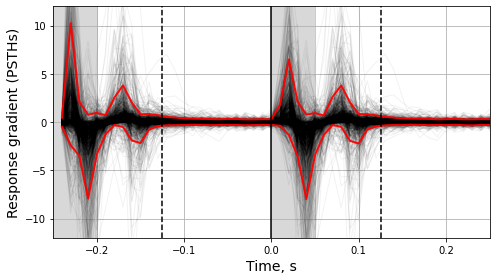

In [62]:
# gradient - for all profiles
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

for i, profile in enumerate(psths):
    ax.plot(bins + bin_size, np.roll(np.gradient(profile), 1), lw=1, color='black', alpha=0.05)
ax.plot(bins + bin_size, confidence_l, lw=2, color='red', alpha=0.95)
ax.plot(bins + bin_size, confidence_h, lw=2, color='red', alpha=0.95)
    
ax.axvline(0, color='black')
ax.axvline(-0.125, color='black', lw=1.5, ls='--')
ax.axvline(0.125, color='black', lw=1.5, ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.axvspan(-0.25, -0.2, alpha=0.3, color='gray')
ax.set_xlim(-hw, hw)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Response gradient (PSTHs)', fontsize=14)
ax.grid()
ax.set_ylim(-12, 12)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'PSTH_gradients.png'), dpi=300)